<a href="https://colab.research.google.com/github/ivan-shargin/cvr_course/blob/main/mnist_sem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация рукописных цифр [2]: свёрточные сети

MNIST - датасет из 60000+10000 одноканальных изображений 28x28

Измените среду выполнения на GPU

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

tensor(6)


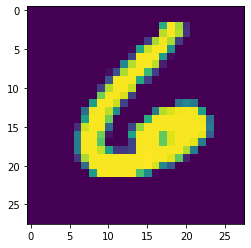

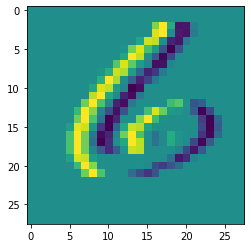

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

for data, target in train_loader:
    for i in range (1):
        print (target [i])
        img = data [i, 0, :, :]
        plt.imshow (img)
        plt.show ()

        #kernel = np.ones((3, 3),np.float32)
        kernel = np.array([[-1, 0, 1]],np.float32)

        #print (type (img))
        convolved = cv2.filter2D(img.detach().cpu().numpy(),-1,kernel)
        plt.imshow (convolved)
        plt.show ()

    break

In [4]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 1, 28, 28])
        x = self.conv1(x)
        #torch.Size([64, 32, 26, 26])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 12, 12])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 9216])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive, train=True):
    train_loss = 0

    if (train):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            #measure loss for archive after backward propagation .
            output = model(data)
            loss = F.nll_loss(output, target) 
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    else:
        model.eval()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
         
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = test_loss / len(test_loader)
    loss_archive.append (test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.266070
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.437898
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.485845
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.427673
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.243600
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.203563
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.295661
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.131490
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.127847
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.338298

Test set: Average loss: 0.2408, Accuracy: 9281/10000 (93%)



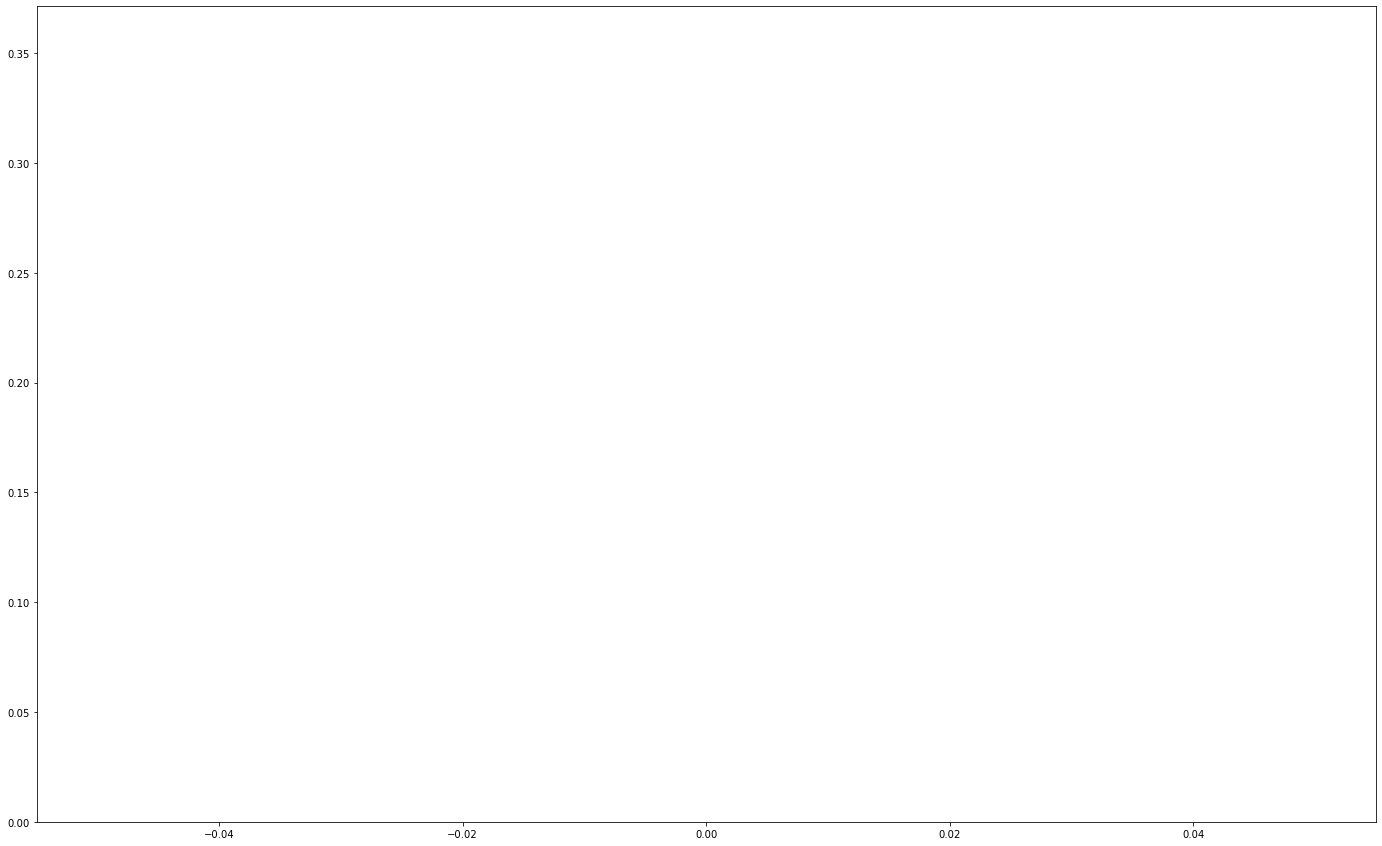

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.157177
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.078854
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.139245
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.200524
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.131461
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.238655
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.178723
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.178588
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.109655
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.058187

Test set: Average loss: 0.1822, Accuracy: 9470/10000 (95%)



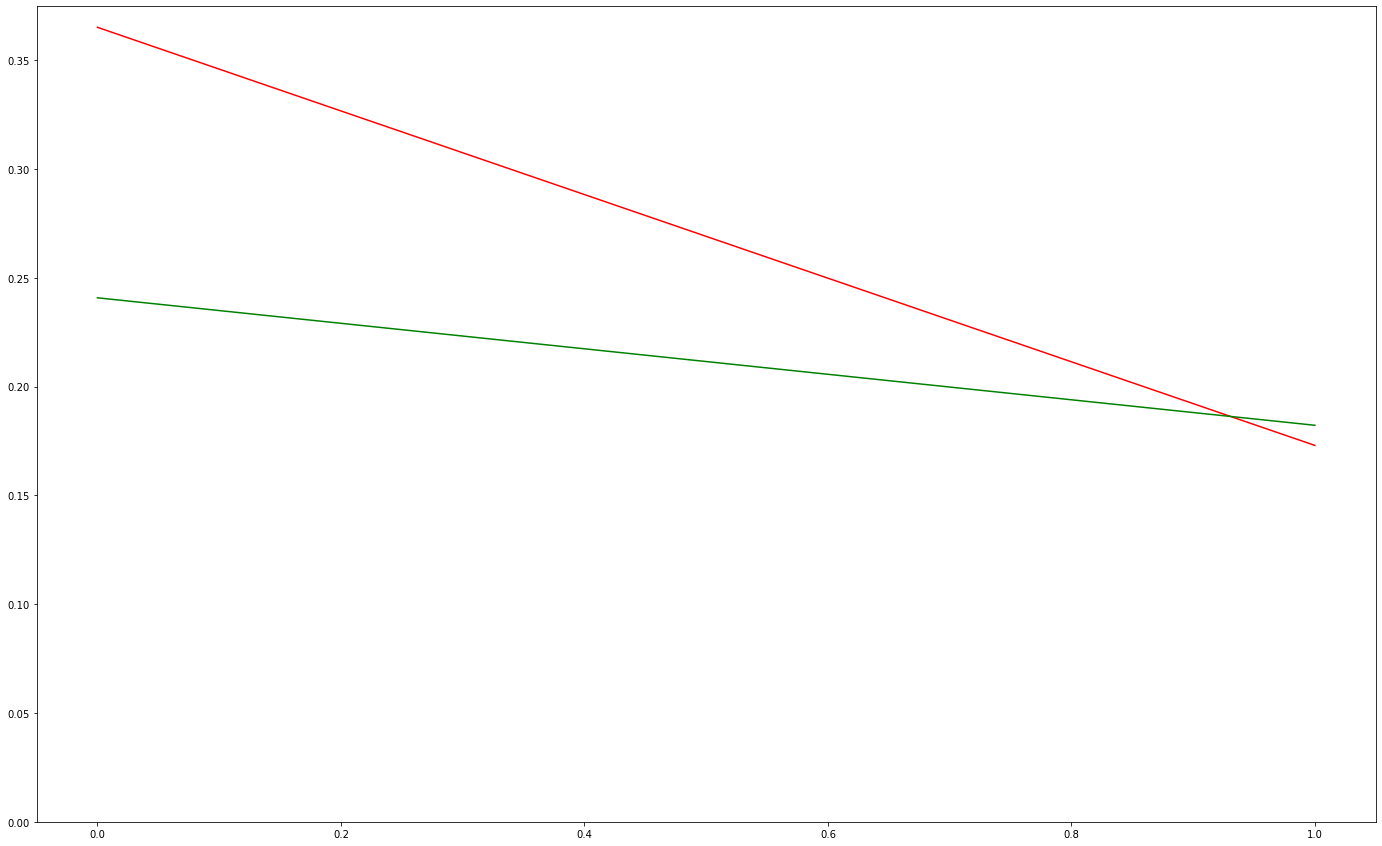

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.149340
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.070815
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.127257
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.161305
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.093130
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.191036
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.187008
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.102333
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.099905
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.112352

Test set: Average loss: 0.1582, Accuracy: 9524/10000 (95%)



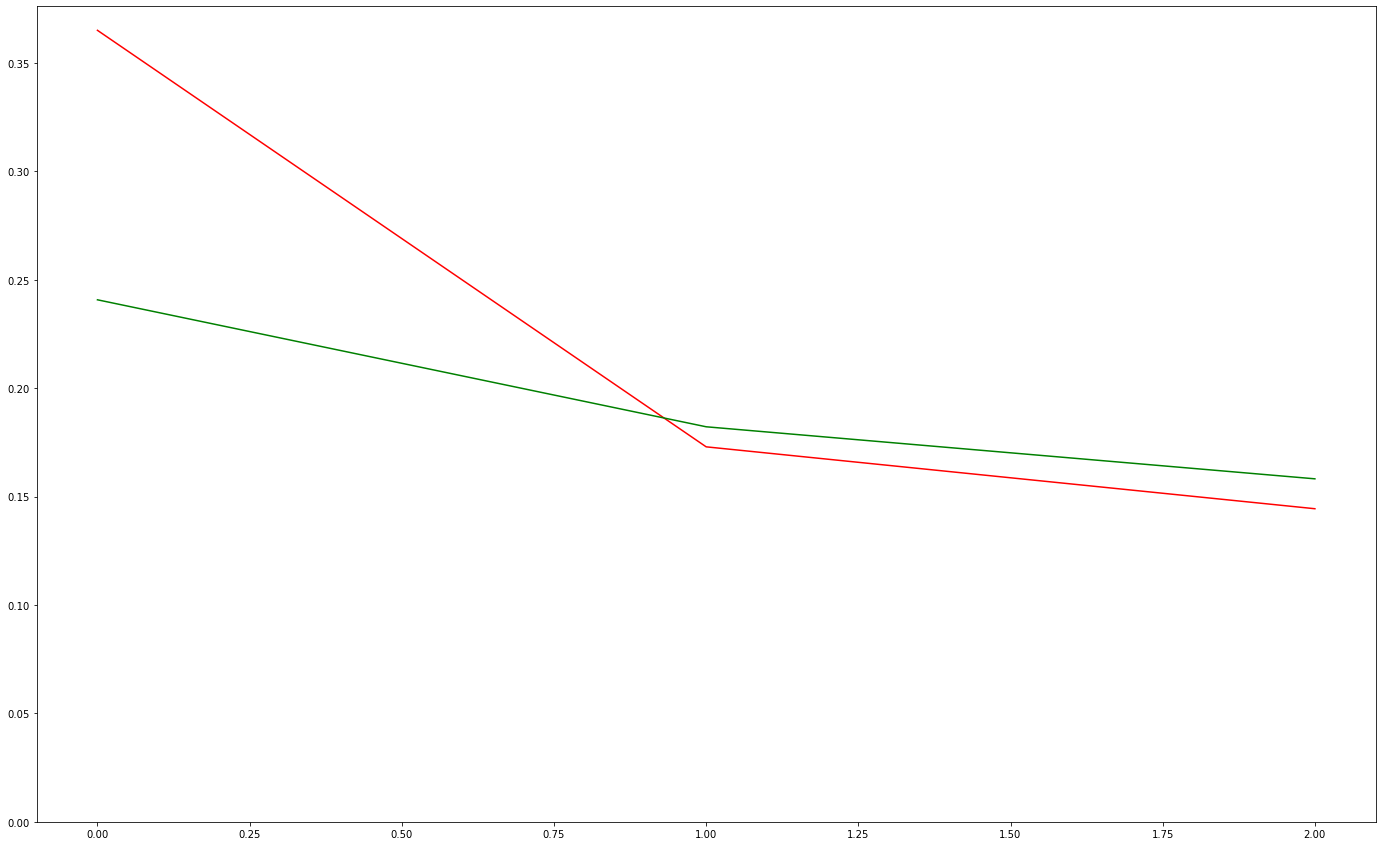

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.075233
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.068777
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.156251
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.122525
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.050786
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.096575
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.145466
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.220848
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.090313
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.048565

Test set: Average loss: 0.1440, Accuracy: 9559/10000 (96%)



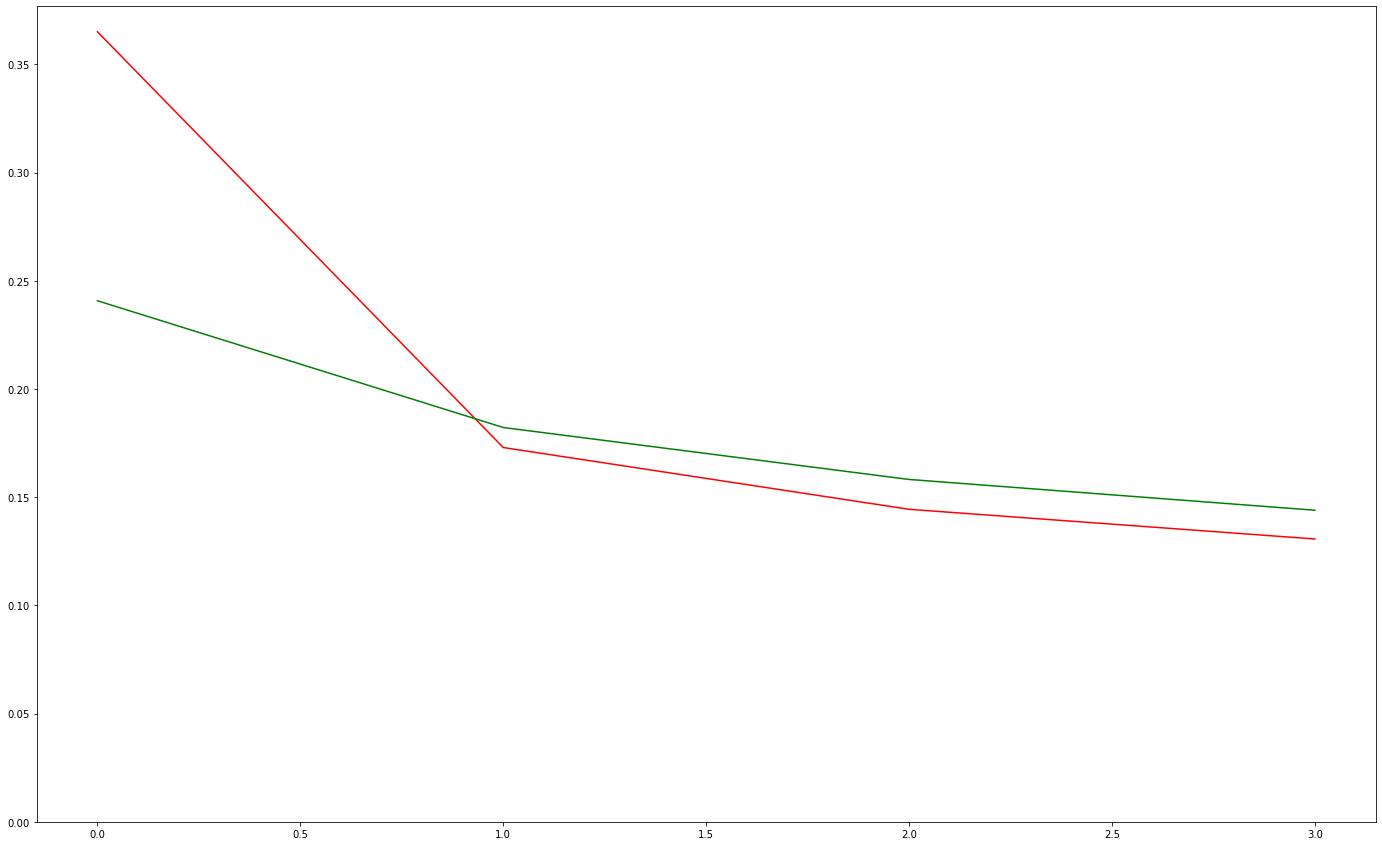

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.290101
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.082093
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.091599
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.113754
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.140881
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.088709
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.222739
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.126458
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.087714
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.044438

Test set: Average loss: 0.1352, Accuracy: 9589/10000 (96%)



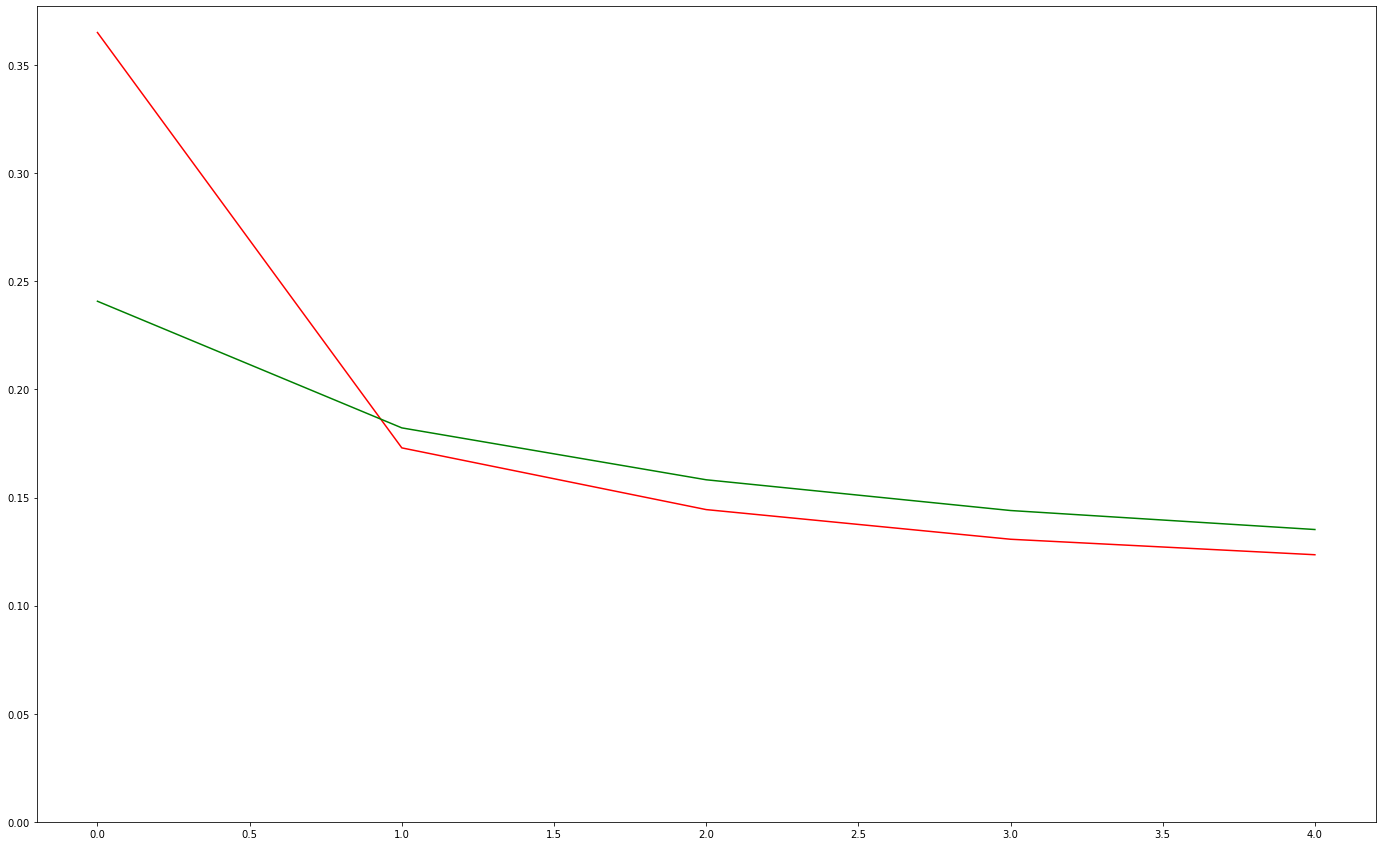

In [6]:
# #первые пять эпох уже были обучены и сохранены, начнем с шестой
# epochs          = 5
# lr              = 0.1
# gamma           = 0.7
# seed            = 1
# log_interval    = 100

# torch.manual_seed(seed)
# device = torch.device("cuda" if use_cuda else "cpu")


# model = Conv_net().to(device)

# optimizer = optim.Adadelta(model.parameters(), lr=lr)

# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# train_loss = []
# test_loss  = []

# plt.ion()

# for epoch in range(1, epochs + 1):
#     train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    
#     test(model, device, test_loader, test_loss)
    
#     scheduler.step()

#     #clear_output(wait = True)

#     plt.figure (figsize=(24, 15))
    
#     plt.plot (train_loss, 'r')
#     plt.plot (test_loss, 'g')
#     plt.ylim(ymin=0)

#     plt.show ()

#     plt.pause (0.01)

# torch.save(model, "first_5_epochs.pth")

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.065646
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.048528
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.082234
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.047058
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.062522
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.044288
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.088655
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.025125
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.078900
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.038599

Test set: Average loss: 0.1198, Accuracy: 9646/10000 (96%)



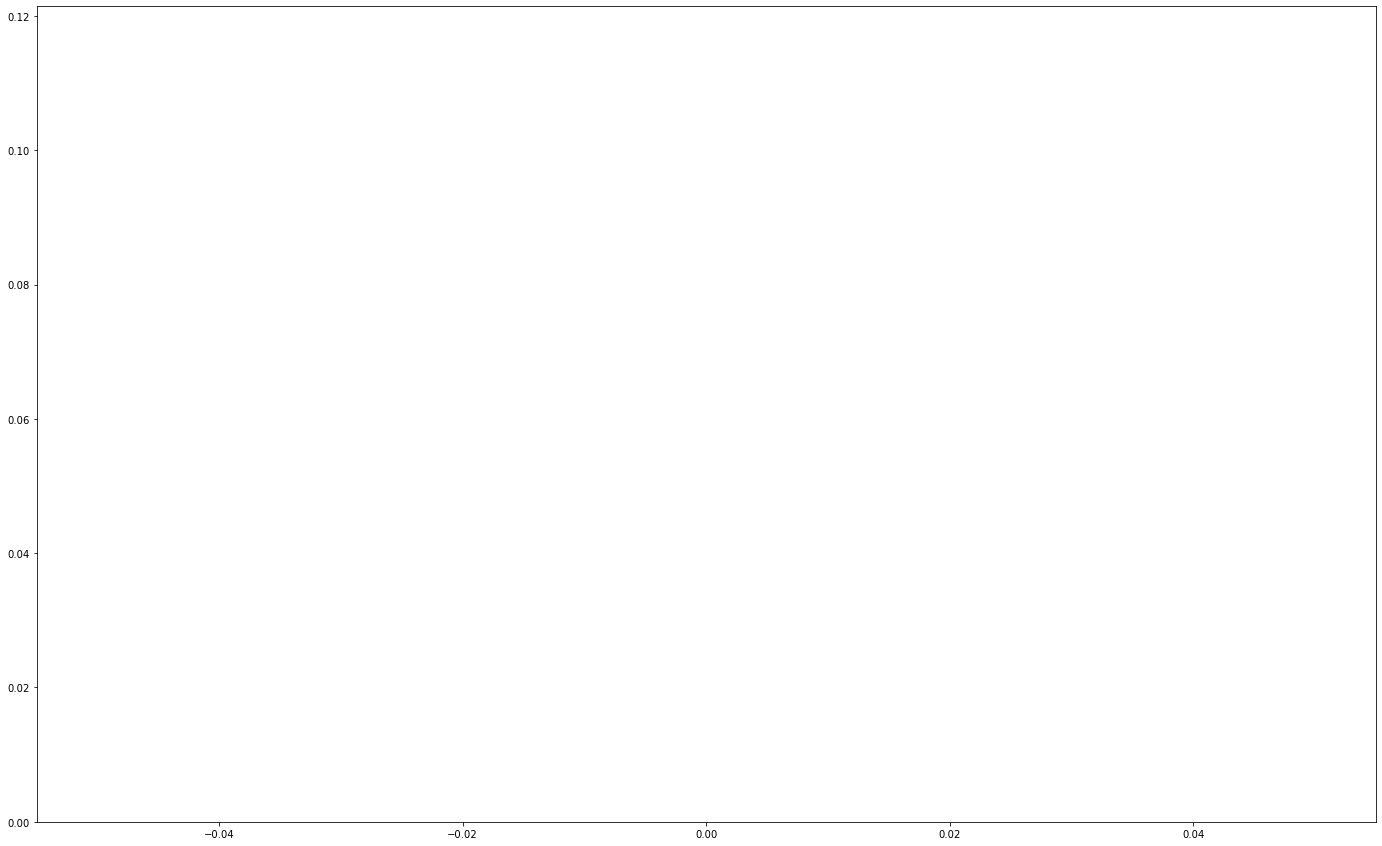

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.080895
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.072496
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.133934
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.067370
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.219659
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.116399
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.024978
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.029690
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.027450
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.070578

Test set: Average loss: 0.1080, Accuracy: 9672/10000 (97%)



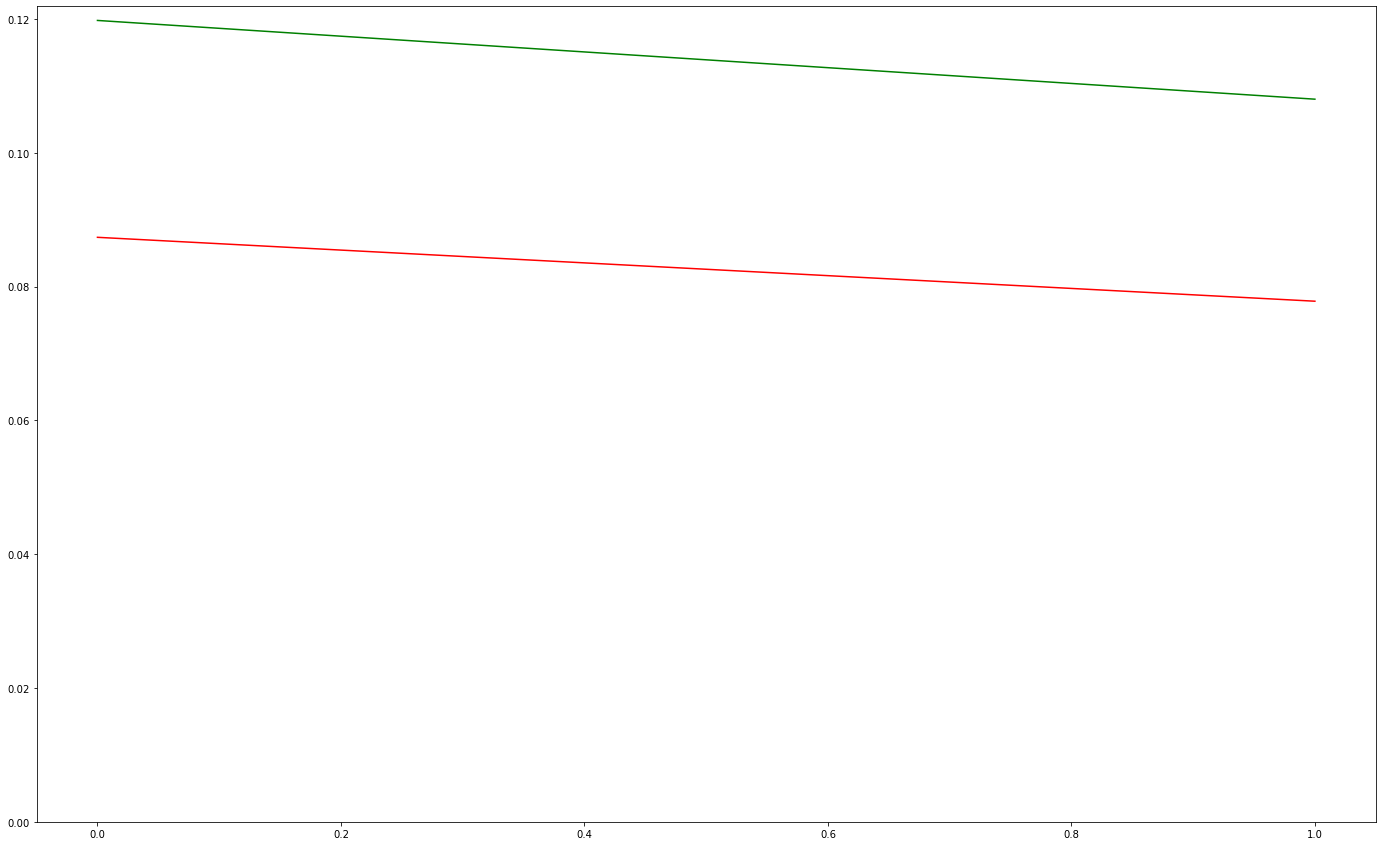

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.140031
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.064987
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.080919
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.094437
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.063337
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.048171
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.151144
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.091037
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.084786
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.021880

Test set: Average loss: 0.1033, Accuracy: 9686/10000 (97%)



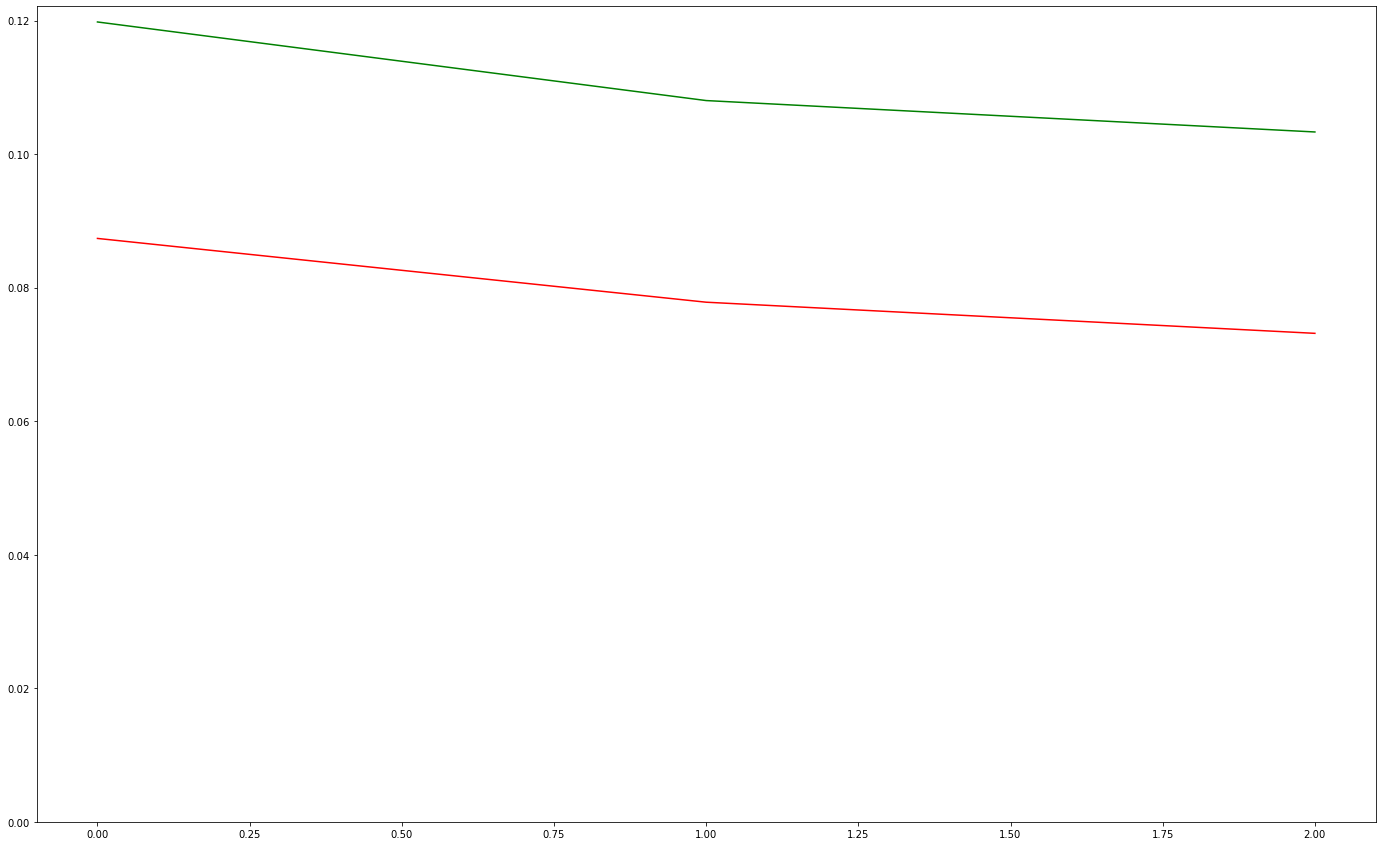

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.038014
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.032407
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.071040
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.102161
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.070740
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.130884
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.052185
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.085891
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.038996
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.021882

Test set: Average loss: 0.0972, Accuracy: 9697/10000 (97%)



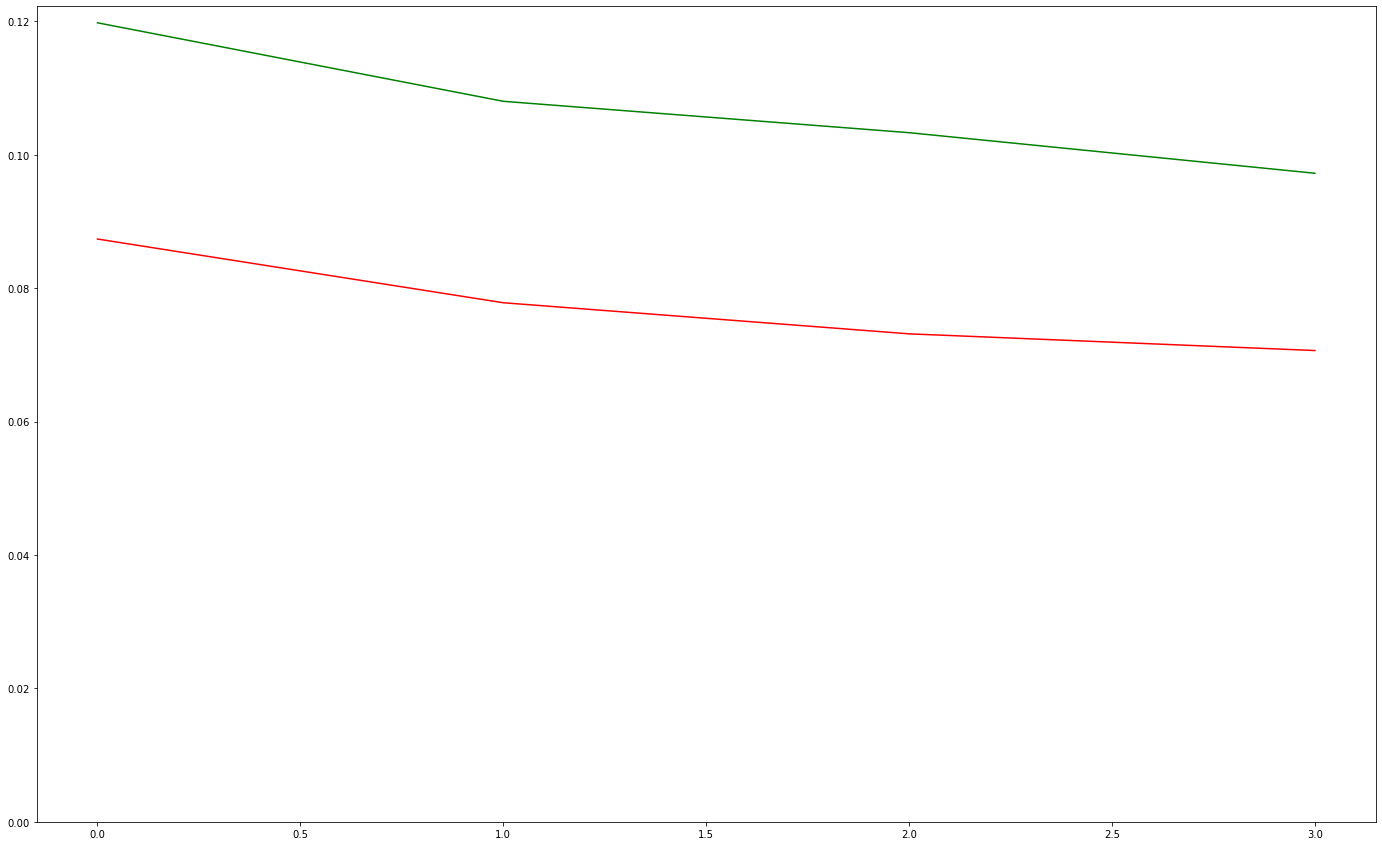

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.059406
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.171141
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.014085
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.065330
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.043498
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.037721
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.193630
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.164235
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.116943
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.030319

Test set: Average loss: 0.0953, Accuracy: 9702/10000 (97%)



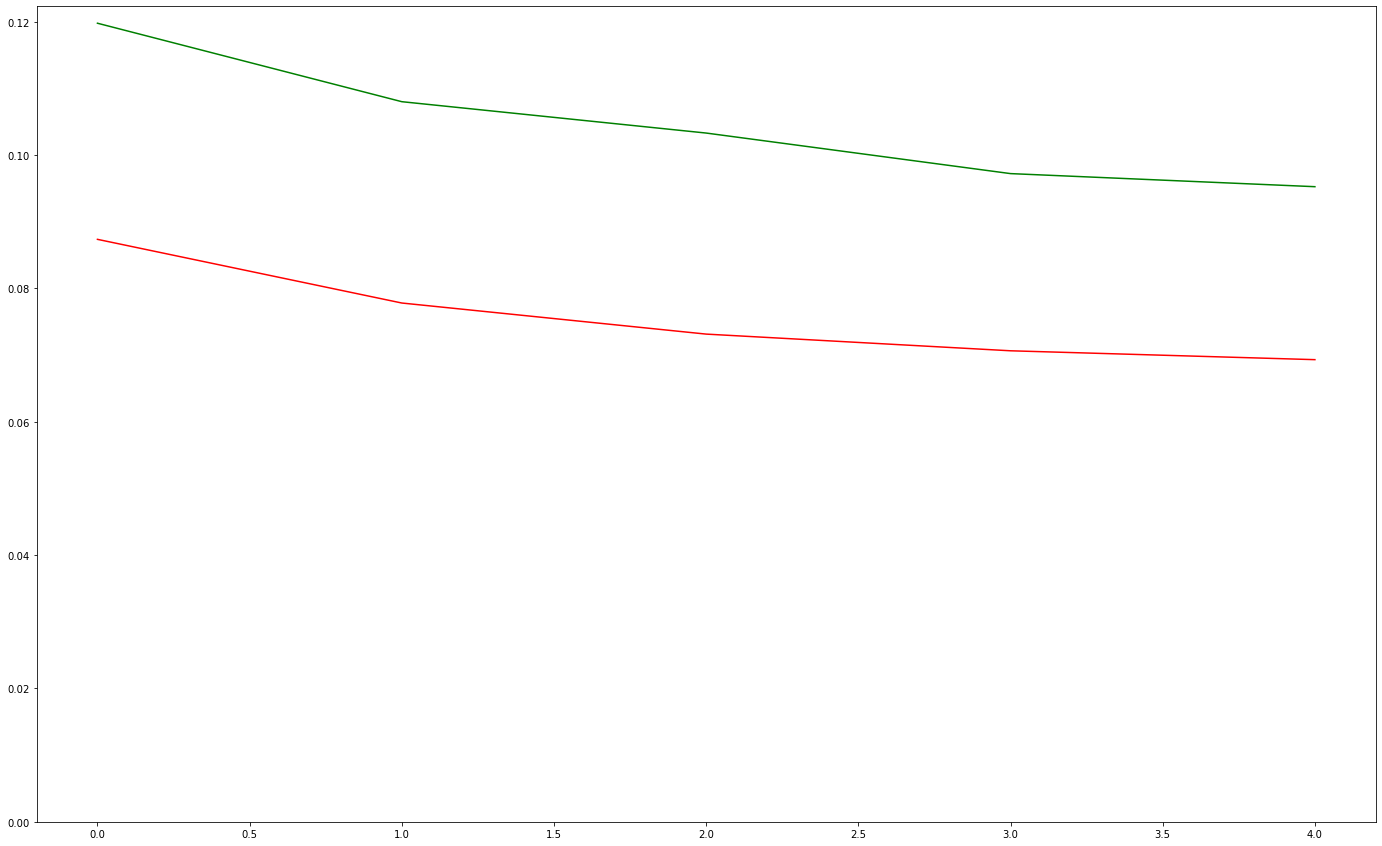

In [7]:
model = torch.load("first_5_epochs.pth")
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(6, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    
    test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

torch.save(model, "first_10_epochs.pth")

Ответ на загадку. Грубая ошибка была в том, что в изначальном коде сеть не просто считала loss на тестовых данных но еще и обучалась на них, что недопустимо. Кроме того, test loss меньше train loss, так как train loss считался перед эпохой обучения, а test loss после той же эпохи. Соответственно, мы должны сохранять loss после back propagation, т.е. должны измерять loss еще и после optimizer.step(). Это я и сделал - смотреть по ссылке https://github.com/ivan-shargin/cvr_course/blob/main/mnist_sem2.ipynb. Еще одно решение заключается в том, чтобы сначала считать test loss а уже потом train loss, но тогда каждый график относился бы к более ранней эпохе.